In [94]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import transformers
from transformers import AutoModelForSequenceClassification,XLMRobertaTokenizer, get_scheduler
from datasets import load_dataset

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
transformers.logging.set_verbosity_error()

In [95]:
class CFG:
    batch_size = 64
    sequence_length = 128
    epochs = 4
    learning_rate = 1e-5
    weight_decay = 0.01

## Exploratory Data Analysis

In [96]:
# train_data = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
# test_data = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
# train_data.head()

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [97]:
print("Number of rows and columns in train data : ",train_data.shape)
print("Number of rows and columns in test data : ",test_data.shape)

Number of rows and columns in train data :  (12120, 6)
Number of rows and columns in test data :  (5195, 5)


In [98]:
# https://huggingface.co/datasets/nyu-mll/multi_nli
def load_mnli_dataset():
  mnli_dataset = load_dataset('multi_nli')
  result = []

  for data in mnli_dataset['train']:
    x1, x2, y = data['premise'], data['hypothesis'], data['label']
    if x1 and x2 and y in {0, 1, 2}:
      result.append((x1, x2, y, 'en'))
  df = pd.DataFrame(result, columns=['premise', 'hypothesis', 'label', 'lang_abv'])
  return df

# loading additional multi-genre NLI dataset
mnli_dataset = load_mnli_dataset()
mnli_dataset.head()

,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en


In [99]:
print("Number of rows and columns in mnli data : ",mnli_dataset.shape)

Number of rows and columns in mnli data :  (392702, 4)


In [100]:
# train/validation/test split
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data = pd.concat([train_data, mnli_dataset.iloc[:100000]], axis=0)

In [101]:
print("Number of rows and columns in concatenated train data : ",train_data.shape)
print("Number of rows and columns in val data : ",val_data.shape)

Number of rows and columns in concatenated train data :  (109696, 6)
Number of rows and columns in val data :  (2424, 6)


### Distribution of Labels:

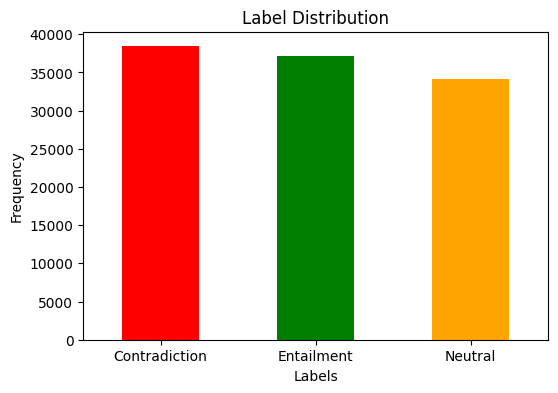

In [102]:
plt.figure(figsize=(6, 4))
label_counts = train_data.label.value_counts()
label_counts.index = label_counts.index.map({0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'})
label_counts.plot(kind='bar', color=['red', 'green', 'orange'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

**Numbers of all layers:**<br><br>
Contradiction: 38404<br>
Entailment: 37128<br>
Neutral: 34164<br>

- We can observe there is no significant class imbalance in the data

### Distribution of Languages:

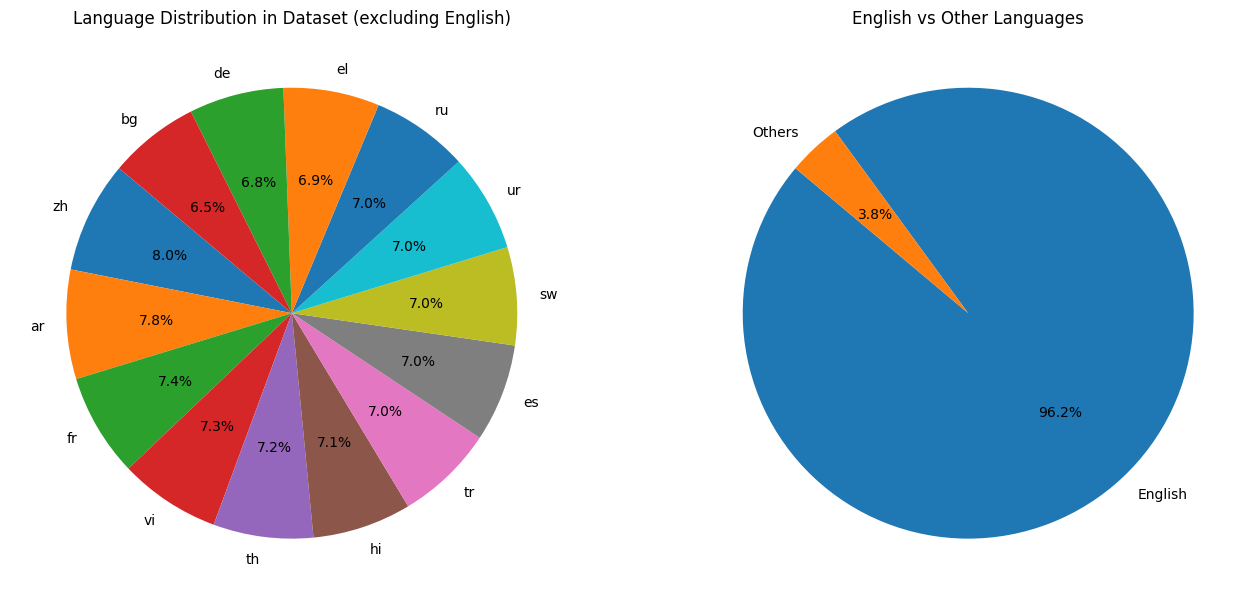

In [103]:
language_counts = train_data['lang_abv'].value_counts()

plt.figure(figsize=(16, 8))

# Distribution of languages other than English
plt.subplot(1, 2, 1)  # 1 row and 2 columns
other_languages = language_counts[language_counts.index != 'en']
plt.pie(other_languages, labels=other_languages.index, autopct='%1.1f%%', startangle=140)
plt.title('Language Distribution in Dataset (excluding English)')

# Visualize the distribution of English alone
plt.subplot(1, 2, 2)  # 1 row and 2 columns
plt.pie([language_counts['en'], other_languages.sum()], labels=['English', 'Others'], autopct='%1.1f%%', startangle=140)
plt.title('English vs Other Languages')

plt.show()

**Language Distribution Analysis:**<br><br>
The dataset has a balanced mix of non-English languages, each language making up approximately 6.5% to 8.0% of the non-English portion. This equal distribution is excellent for training models to handle multiple languages equally without favoring any particular one. However, with English making up 96.2% of the dataset, it's clear that English is the dominant language. This heavy imbalance can affect the model’s ability to perform well across other languages. To improve, consider collecting more data in non-English languages to ensure the model performs well globally.

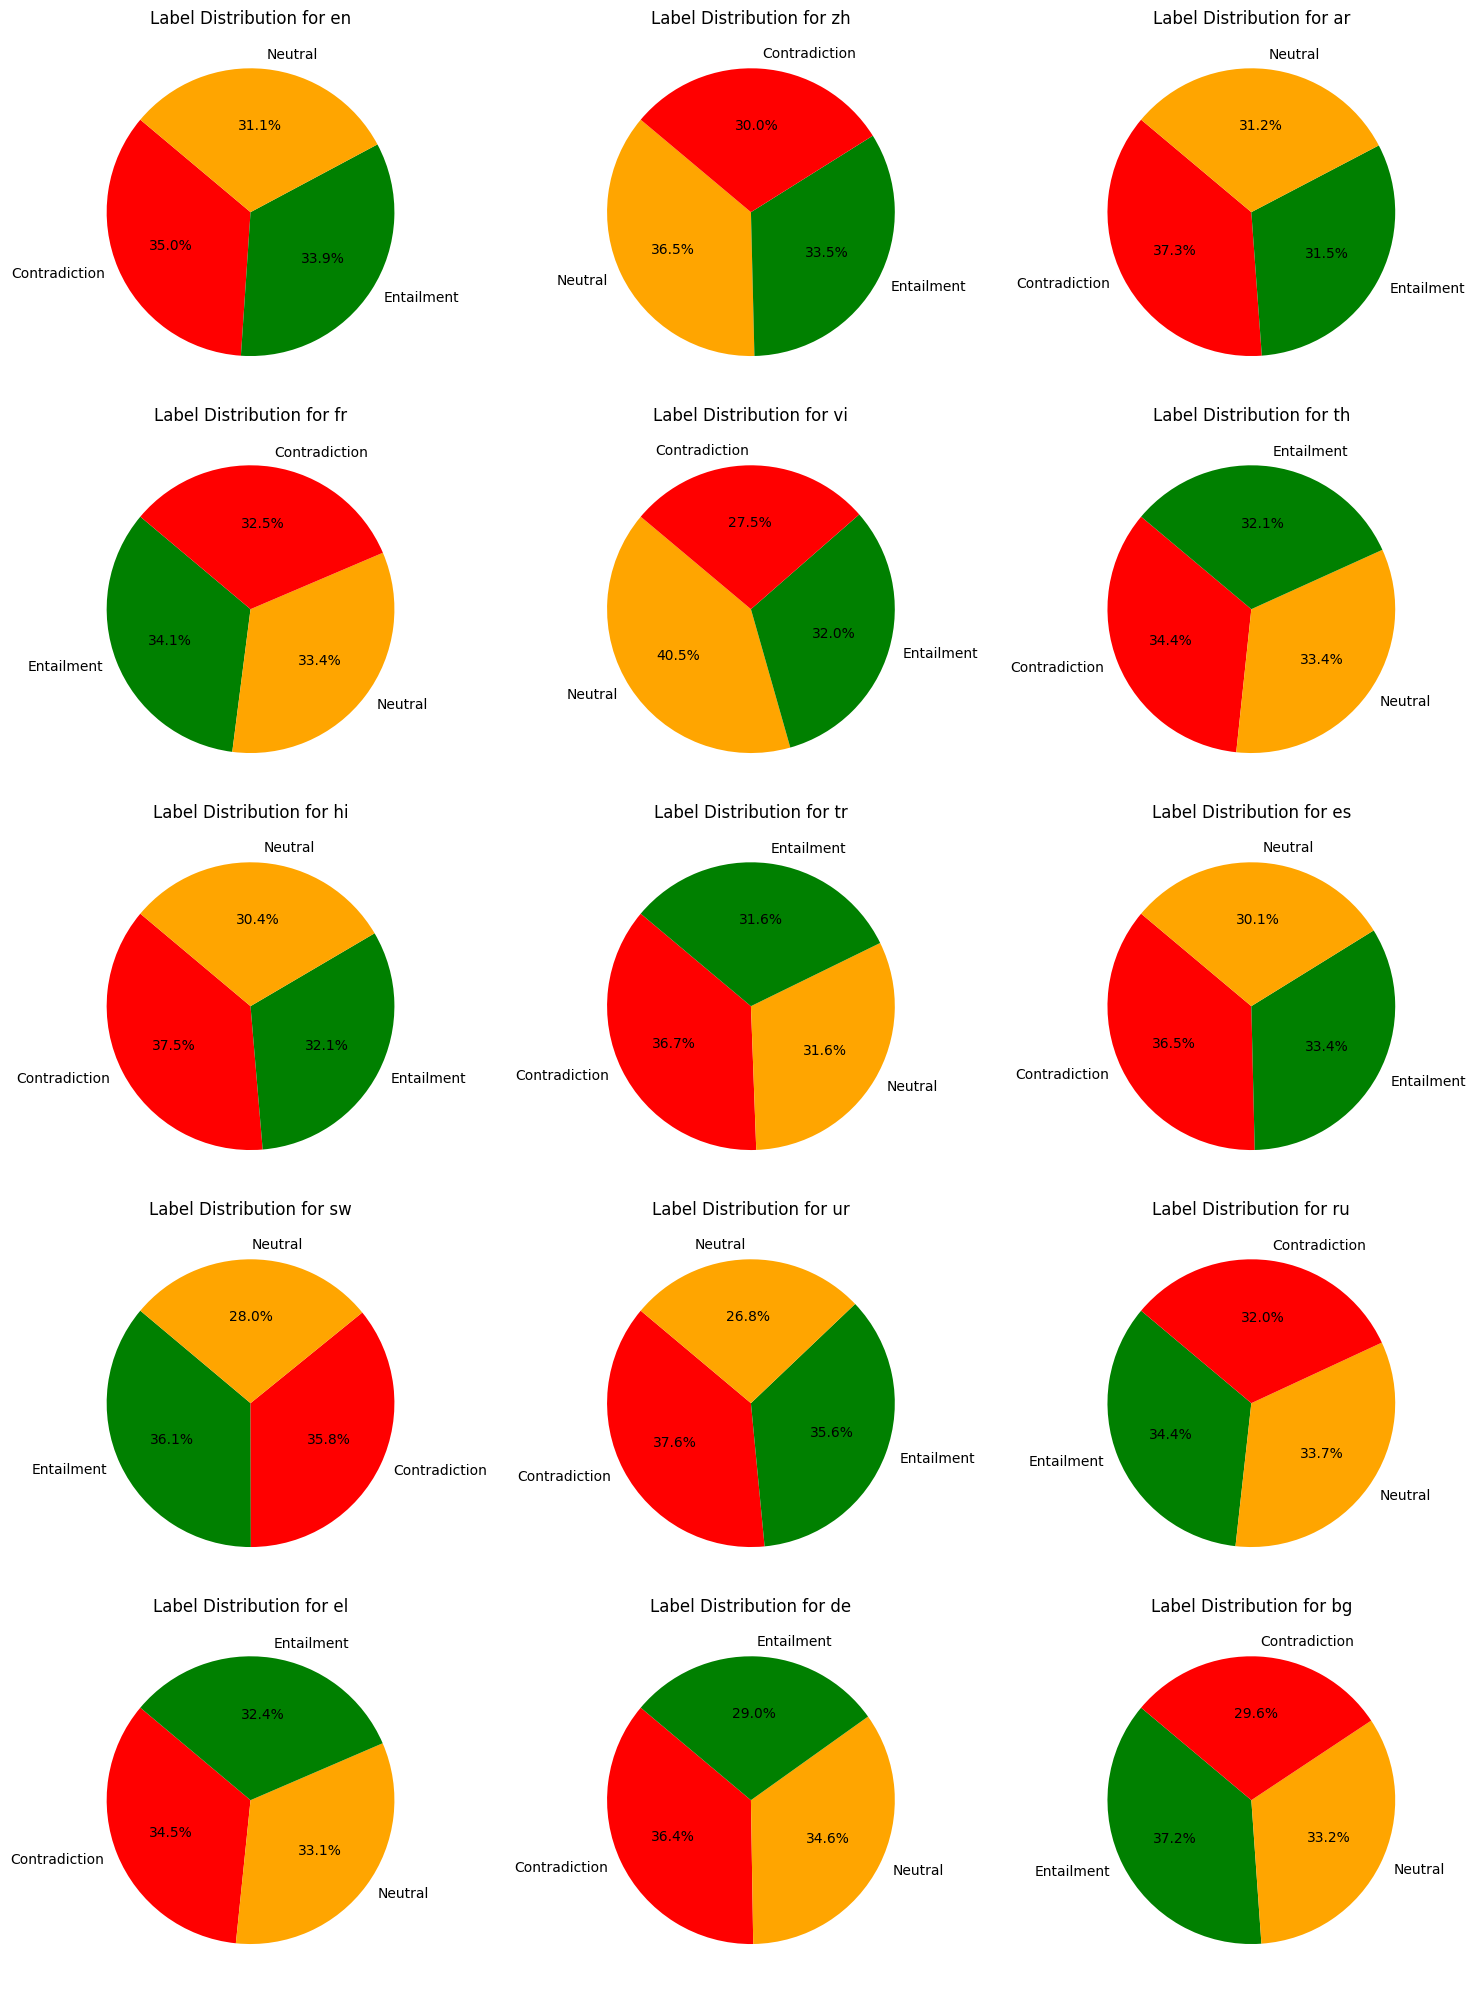

In [104]:
num_languages = len(language_counts)
cols = 3  # Three charts per row
rows = np.ceil(num_languages / cols).astype(int)  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))  # Set the height for each row

# Define a color map for the labels
colors = {
    'Entailment': 'green', 
    'Neutral': 'orange',   
    'Contradiction': 'red'  
}

# Visualize label distribution for each language
for i, language in enumerate(language_counts.index):
    ax = axes.flatten()[i]  # Flatten the axes array and access the correct subplot
    language_data = train_data[train_data['lang_abv'] == language]
    label_distribution = language_data['label'].value_counts()
    label_distribution.index = label_distribution.index.map({0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'})

    # Draw the pie chart
    ax.pie(label_distribution, labels=label_distribution.index, autopct='%1.1f%%', startangle=140, colors=[colors[label] for label in label_distribution.index])
    ax.set_title(f'Label Distribution for {language}')

# Hide empty axes (if any)
for j in range(i + 1, rows * cols):
    axes.flatten()[j].axis('off')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

**Label Distribution Across Languages:**<br><br>
The pie charts illustrate that the dataset has a fairly uniform distribution of labels (Contradiction, Entailment, Neutral) across multiple languages including English, French, Spanish, Chinese, Vietnamese, Thai, and Hindi. No significant class imbalance is evident within any specific language, with each label represented approximately equally. This uniformity is beneficial for training unbiased models capable of consistent performance across different linguistic contexts.

### Analysis of Text Length Distribution:

Premise Length Statistics:
 count    109696.000000
mean        112.716708
std          78.886350
min           5.000000
25%          55.000000
50%          98.000000
75%         151.000000
max        1415.000000
Name: premise_length, dtype: float64

Hypothesis Length Statistics:
 count    109696.000000
mean         55.862702
std          25.047562
min           1.000000
25%          39.000000
50%          53.000000
75%          69.000000
max         341.000000
Name: hypothesis_length, dtype: float64


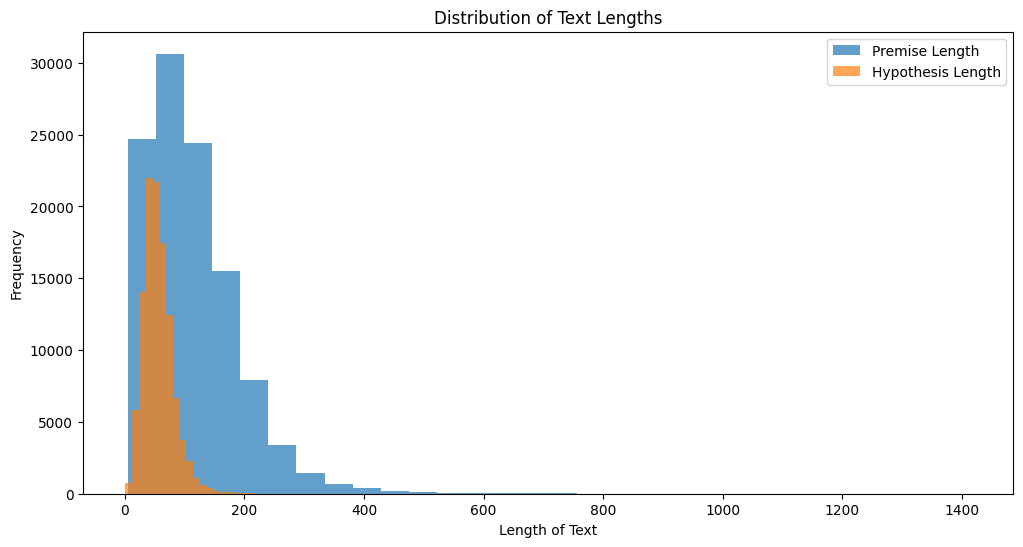

In [105]:
data = train_data.copy()

# Calculate the length of 'Premise' and 'Hypothesis' columns
data['premise_length'] = data['premise'].apply(len)
data['hypothesis_length'] = data['hypothesis'].apply(len)

# Print statistical summary of text lengths
print("Premise Length Statistics:\n", data['premise_length'].describe())
print("\nHypothesis Length Statistics:\n", data['hypothesis_length'].describe())

# Plot histograms for the lengths of the text
plt.figure(figsize=(12, 6))
plt.hist(data['premise_length'], bins=30, alpha=0.7, label='Premise Length')
plt.hist(data['hypothesis_length'], bins=30, alpha=0.7, label='Hypothesis Length')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Text Length Distribution Insight:**<br><br>
The histogram reveals that both Premise and Hypothesis are typically concise, with most texts under 200 characters and a peak around 50 characters. This indicates a dataset comprised of brief statements, ideal for models focusing on quick text processing. The similar length distribution for both fields suggests a balanced dataset that minimizes length-based bias in model training.

## Setting Model

In [ ]:
model_path = 'joeddav/xlm-roberta-large-xnli'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
#PATH = '/kaggle/input/xlm-roberta-large-xnli-fine-tuned/pytorch/default/1/BERT_ft_epochmodel.model'
#model.load_state_dict(torch.load(PATH, weights_only=True))

In [ ]:
class ContradictoryDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokens = tokenizer(
            df['premise'].tolist(),
            df['hypothesis'].tolist(),
            max_length = CFG.sequence_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        if 'label' in df.keys():
          self.labels = torch.tensor(df['label'].tolist())


    def __len__(self):
        return self.tokens["input_ids"].shape[0]

    def __getitem__(self, idx):
      if 'label' in self.df.keys():
        return (
            self.tokens["input_ids"][idx], 
            self.tokens["attention_mask"][idx],
            self.labels[idx]
        )
      return (
            self.tokens["input_ids"][idx], 
            self.tokens["attention_mask"][idx],
        )

In [ ]:
# creating datasets
train_dataset = ContradictoryDataset(train_data, tokenizer)
val_dataset = ContradictoryDataset(val_data, tokenizer)
test_dataset = ContradictoryDataset(test_data, tokenizer)

# creating dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    num_workers=0
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=CFG.batch_size,
    num_workers=0
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=CFG.batch_size,
    num_workers=0
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)

model.to(device)

In [ ]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, epoch):
    train_loss = 0.0
    train_f1 = 0.0
    train_progress_bar = tqdm(train_dataloader, desc="Epoch {:1d}".format(epoch), leave=False, disable=False)
    
    for i, batch in enumerate(train_progress_bar):
      optimizer.zero_grad()
      batch = tuple(b.to(device) for b in batch)
    
      inputs = {
          'input_ids': batch[0],
          'attention_mask': batch[1],
          'labels': batch[2]
      }
          
      outputs = model(**inputs)
      loss = outputs[0]
      logits = outputs[1]
      
    
      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
    
      y_pred = np.argmax(logits, axis=1)
      y_true = label_ids
        
      train_loss += loss.item()
      train_f1 += f1_score(y_true, y_pred, average='weighted')
    
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      loss.backward()
      optimizer.step()
        
      train_progress_bar.set_postfix({'train_loss': f'{(train_loss / (i + 1)):.4f}', 'train_f1': f'{(train_f1 / (i + 1)):.4f}'})

    return train_loss / len(train_dataloader), train_f1 / len(train_dataloader)


In [ ]:
def validate(model, val_dataloader, criterion, epoch):
    val_loss = 0.0
    val_f1 = 0.0
    val_progress_bar = tqdm(val_dataloader, desc="Epoch {:1d}".format(epoch), leave=False, disable=False)

    for i, batch in enumerate(val_progress_bar):
        batch = tuple(b.to(device) for b in batch)
        inputs = {
          'input_ids': batch[0],
          'attention_mask': batch[1],
          'labels': batch[2]
          }

        with torch.no_grad():
          outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()

        y_pred = np.argmax(logits, axis=1).flatten()
        y_true = label_ids

        val_loss += loss.item()
        val_f1 += f1_score(y_true, y_pred, average='weighted')
    
        val_progress_bar.set_postfix({'val_loss': f'{(val_loss / (i + 1)):.4f}', 'val_f1': f'{(val_f1 / (i + 1)):.4f}'})

    return val_loss / len(val_dataloader), val_f1 / len(val_dataloader)

In [ ]:
def test(model, test_dataloader):
    model.eval()
    y_pred = []
    test_progress_bar = tqdm(test_dataloader, desc="Test", leave=False, disable=False)

    for batch in test_progress_bar:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
          'input_ids': batch[0],
          'attention_mask': batch[1],
          }

        with torch.no_grad():
          outputs = model(**inputs)
        logits = outputs[0]        
        logits = logits.detach().cpu().numpy()
        y_pred.extend(np.argmax(logits, axis=1)) 

    return y_pred

In [ ]:
def train(model, train_dataloader, criterion, optimizer, epochs):
    model.train()
    train_losses = []
    val_losses = []

    train_scores = []
    val_scores = []
    
    for epoch in range(epochs):
      # training mode
      model.train()
      train_loss, train_f1 = train_one_epoch(model, train_dataloader, criterion, optimizer, epoch+1)
      train_losses.append(train_loss)
      train_scores.append(train_f1)

      # validation mode
      model.eval()
      val_loss, val_f1 = validate(model, val_dataloader, criterion, epoch+1)
      val_losses.append(val_loss)
      val_scores.append(val_f1)

      # saving model checkpoints in each epoch
      torch.save(model.state_dict(), 'BERT_MNLI_epoch{}.model'.format(epoch+1))

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_score': train_scores,
        'val_score': val_scores,
    }

In [ ]:
# training the model and getting the history of loss and f1 score
history = train(model, train_dataloader, criterion, optimizer, CFG.epochs)

In [ ]:
# getting test predictions
y_preds = test(model, test_dataloader)
submission = test_data.id.copy().to_frame()
submission['prediction'] = y_preds
submission.to_csv("submission.csv", index=False)
submission.head()

In [ ]:
submission = test_data.id.copy().to_frame()
submission['prediction'] = preds
submission.to_csv("submission.csv", index=False)
submission.head()